In [1]:
%load_ext autoreload
%autoreload 2
from simulation_enviroment import DemandResponseEviroment, Cell
from policies import *
import policies
from noise_functions import gaussian_stochastic,identity
from pricing_generators import *
from reward_functions import *
import sys
import seaborn as sns
import importlib
from sklearn.metrics import mean_squared_error

In [2]:
%matplotlib inline
length = 1440
sys.setrecursionlimit(length * 10)



In [3]:
l1, l2, l3 = (0.01, 0.01, 0.01)

In [4]:
def reward_function(s, cells):
    #return boundary_exceedence_cost(s, cells)
    return l1 * energy_price_cost(s, cells) + l2 * switch_cost(s, cells) +  l3 * boundary_exceedence_cost(s, cells)

In [5]:
gamma = -1 * (1/length - 1)
gamma = 0.9
print(gamma)

0.9


In [6]:
cell = Cell(max_temp=1., min_temp=0.8)

In [7]:
env =  DemandResponseEviroment(episode_length=length * 2,  noise_function=gaussian_stochastic, 
                               pricing_generator=ApxShiftPricingGenerator, cells = [cell])

# Q-function computation

Recursively compute the Q value of a state action tuple, record intermediate results: $$Q(s, a) =  R(s, a) + \max_a \gamma Q(s', a')$$

In [ ]:
rewards = []
states = []

errors_rewards = []
def play(pol, t, update = True, record_states = False):
    if t > length * 2 + 1:
        return 0
    s , cells = env.get_global_state(), env.cells
    action = pol.policy(s, cells)
    env.execute_action(action)
    ns , ncells = env.get_global_state(), env.cells
    reward = reward_function(ns, ncells) + gamma  * play(pol, t + 1, update, record_states)
    if t < length:
        if update:
            # update the policy (i.e. add new learners)
            pol.update(s, cells, action, ns, ncells, reward)
        
        rewards.append(reward)
        
        if record_states:
            s = list(s.values())
            for a in action:
                s.append(a)
            states.append(np.array(s).reshape(-1,))
            errors_rewards.append(reward)
            
        
    return reward

# Training

In [9]:
p = QLearningQeuedRFPolicy(alpha=0.4, gamma=gamma, epsilon=0.99, length = length, max_depth=15, max_leaf_nodes=1000)
iters = 120
avg_rewards = []
moneys = []
errors = []
for i in range(iters):
    env.start_episode(visualise=False)
    # play one episode
    play(p, 0)
    r = sum(rewards)/len(rewards)
    if not i % 10:
        print('Starting iter..', i, r, p.epsilon)
    avg_rewards.append(r)
    history = env.episode_history
    history_dataframe =  pd.DataFrame(history).T
    realised_price  = history_dataframe['pricing'] * history_dataframe['power_usage']
    moneys.append(realised_price.sum())
    rewards = []
    
print(len(p.dataset))

Starting iter.. 0 -0.674394228955 0.9640619999998941
Starting iter.. 10 -0.567156924897 0.7046819999988347
Starting iter.. 20 -0.38372469367 0.4453019999981128
Starting iter.. 30 -0.173269783667 0.1859219999984557
Starting iter.. 40 -0.00953890371209 -0.07345800000157562
Starting iter.. 50 -0.00682776545942 -0.3328380000015001
Starting iter.. 60 -0.00609211155975 -0.5922180000015284
Starting iter.. 70 -0.00320166571841 -0.8515980000025877
Starting iter.. 80 -0.00356715109629 -1.110978000002278
Starting iter.. 90 -0.00413395770772 -1.3703580000001376
Starting iter.. 100 -0.0064117832092 -1.6297379999979973
Starting iter.. 110 -0.00395741243679 -1.889117999995857
49900


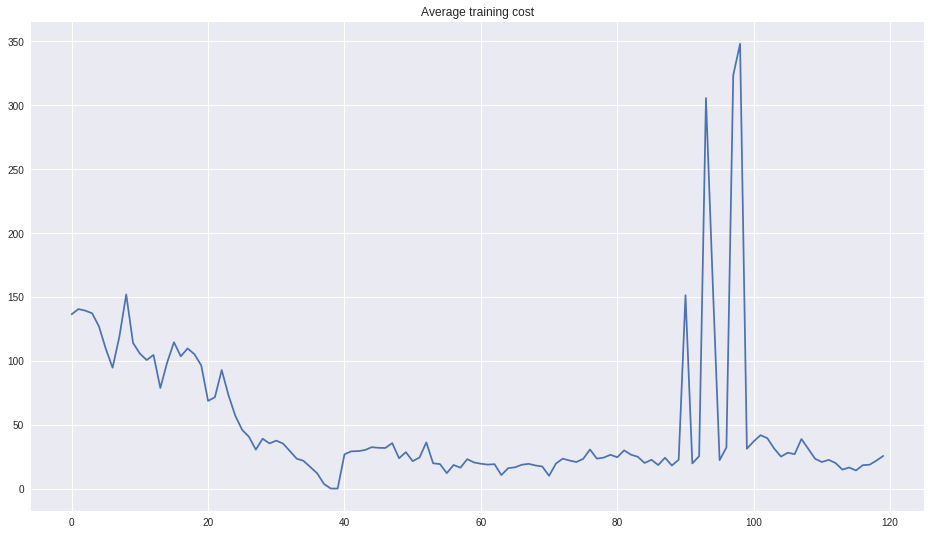

In [10]:

f = plt.figure()
f.set_size_inches(16, 9)
_ = plt.plot(moneys)
plt.title('Average training cost')
    

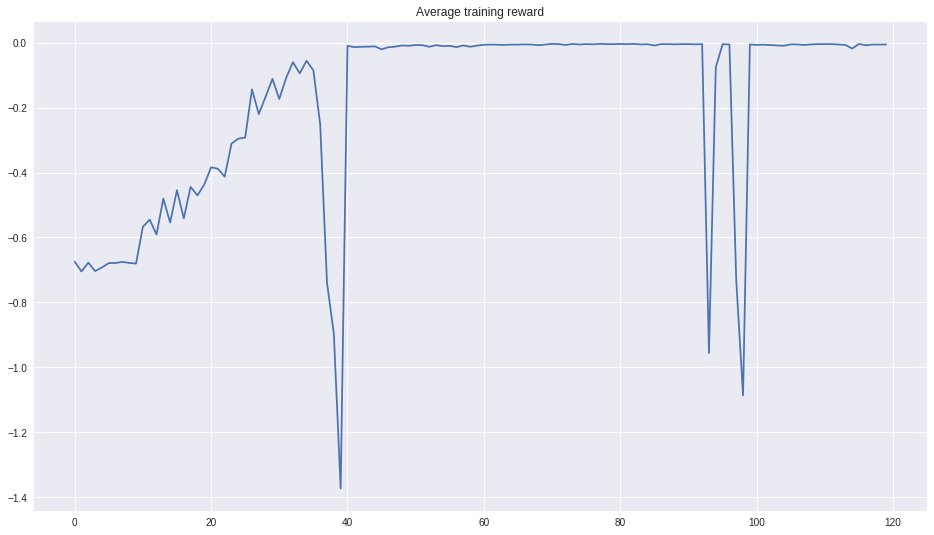

In [11]:
f = plt.figure()
f.set_size_inches(16, 9)
_ = plt.plot(avg_rewards)
plt.title('Average training reward')

# Benchmark policy

VISUALISING
realised_price: 23.033809847969117


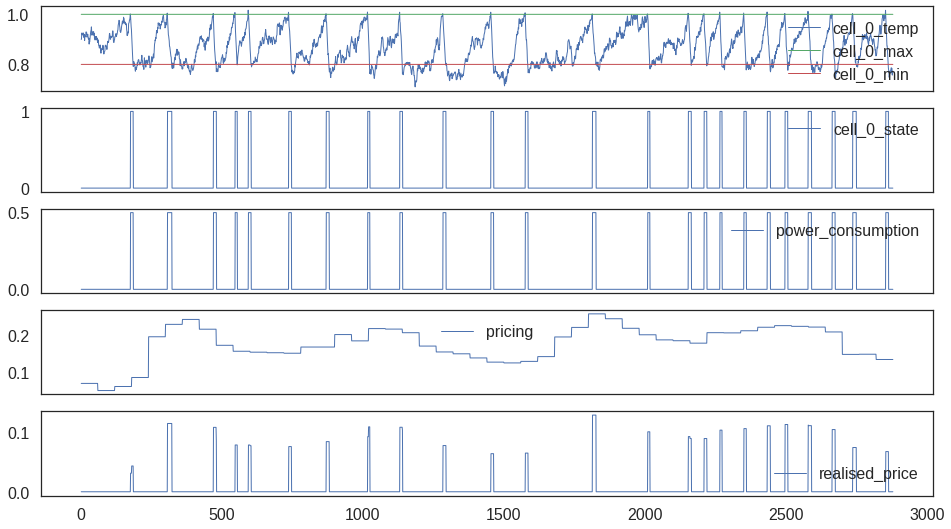

-0.0249434703338


In [12]:
rd = {'lines.linewidth' : 1}
sns.set_style("white")
sns.set_context('poster', rc = rd)
qp = LatestSwitchPolicy(reward_function)
rewards = []
env.start_episode(visualise=True)
play(qp, 0, update=False)
print(sum(rewards)/len(rewards))

# RL policy

VISUALISING
realised_price: 19.195749186899633


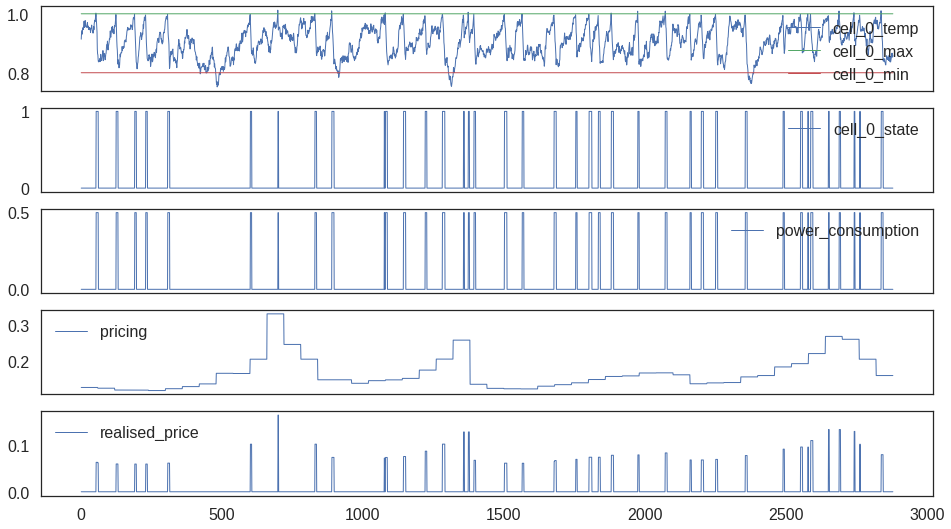

-0.00643160485399
-2.1484979999937166


In [13]:
rewards = []
env.start_episode(visualise=True)
play(p, 0, update=False)
#print(price)
print(sum(rewards)/len(rewards))
print(p.epsilon)

# Compare RL vs. Benchmark

Evaluate RL against the Benchmark policy

In [ ]:
def eval_policy(agent, eps = 100):
    basic_rewards = []
    basic_monays = []
    basic_switches = []
    basic_ons = []
    basic_ptimes = []
    
    for _ in range(eps):   
        #play a number of episodes, and record results
        env.start_episode()
        play(agent, 0, update=False)
        history = env.episode_history
        history_dataframe =  pd.DataFrame(history).T
        realised_price  = history_dataframe['pricing'] * history_dataframe['power_usage']
        basic_monays.append(realised_price.sum())
        basic_rewards.append(sum(rewards)/len(rewards))
        switches = len(history_dataframe['cell_0_state'][history_dataframe['cell_0_state'] - history_dataframe['cell_0_state'].shift(1) != 0.0])
        on_time = sum(history_dataframe['cell_0_state'])/len(history_dataframe)
        price_per_time = realised_price.sum() / sum(history_dataframe['cell_0_state'])
        basic_switches.append(switches)
        basic_ons.append(on_time)
        basic_ptimes.append(price_per_time)
    
    return {
        'rewards' : basic_rewards,
        'cost' : basic_monays,
        'switches' : basic_switches,
        'on_time' : basic_ons,
        'realized' : basic_ptimes
    }


In [15]:
# evaluate benchmark
%prun evals = eval_policy(qp, 50)

In [16]:
# evaluate RL
%prun evals_rl = eval_policy(p, 50)

In [17]:
(basic_monays,
basic_ons,
basic_ptimes,
basic_rewards,
basic_switches
) = (evals['cost'], evals['on_time'], evals['realized'], evals['rewards'], evals['switches'])

In [18]:
(rl_monays,
rl_ons,
rl_ptimes,
rl_rewards,
rl_switches) = (evals_rl['cost'], evals_rl['on_time'], evals_rl['realized'], evals_rl['rewards'], evals_rl['switches'])

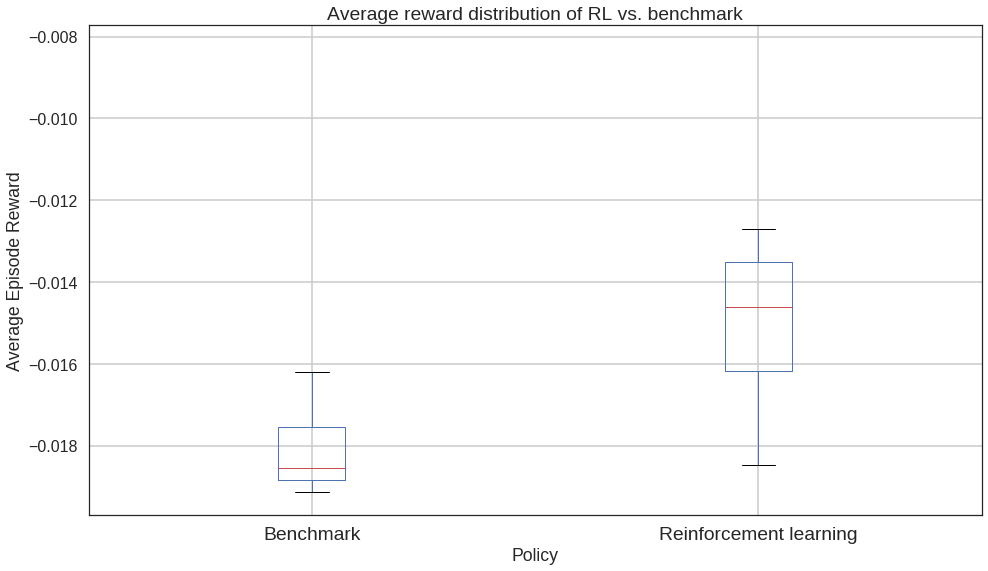

In [19]:
rd = {'lines.linewidth' : 1}
sns.set_style("white")
sns.set_context('poster', rc = rd)
f = plt.figure()
f.set_size_inches(16, 9)
df = pd.DataFrame()
df['Benchmark'] = basic_rewards
df['Reinforcement learning'] = rl_rewards
df.boxplot()
plt.xlabel('Policy')
plt.ylabel('Average Episode Reward')
plt.title('Average reward distribution of RL vs. benchmark')

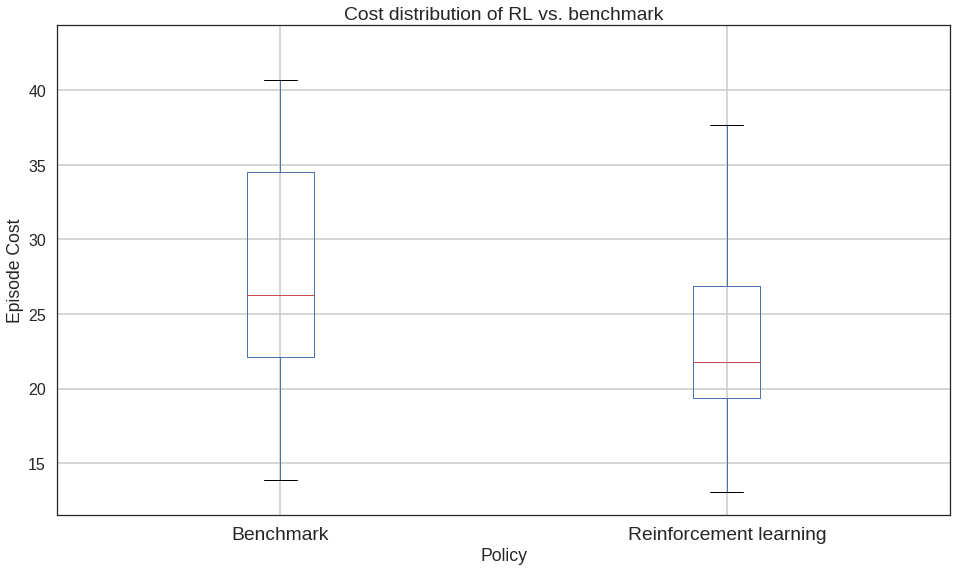

In [20]:
f = plt.figure(facecolor='white')
f.set_size_inches(16, 9)
df = pd.DataFrame()
df['Benchmark'] = basic_monays
df['Reinforcement learning'] = rl_monays
df.boxplot()
plt.xlabel('Policy')
plt.ylabel('Episode Cost')
plt.title('Cost distribution of RL vs. benchmark')

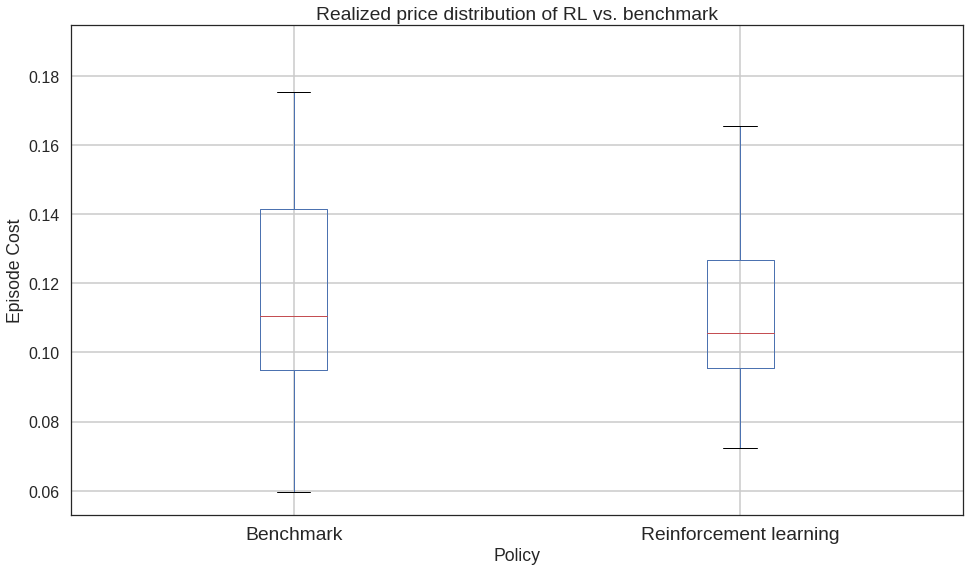

In [21]:
f = plt.figure(facecolor='white')
f.set_size_inches(16, 9)
df = pd.DataFrame()
df['Benchmark'] = basic_ptimes
df['Reinforcement learning'] = rl_ptimes
df.boxplot()
plt.xlabel('Policy')
plt.ylabel('Episode Cost')
plt.title('Realized price distribution of RL vs. benchmark')

# When does RL > Benchmark?

Rl takes time to learn, how long does it take for RL to offer an improvement over the Benchmark Policy?

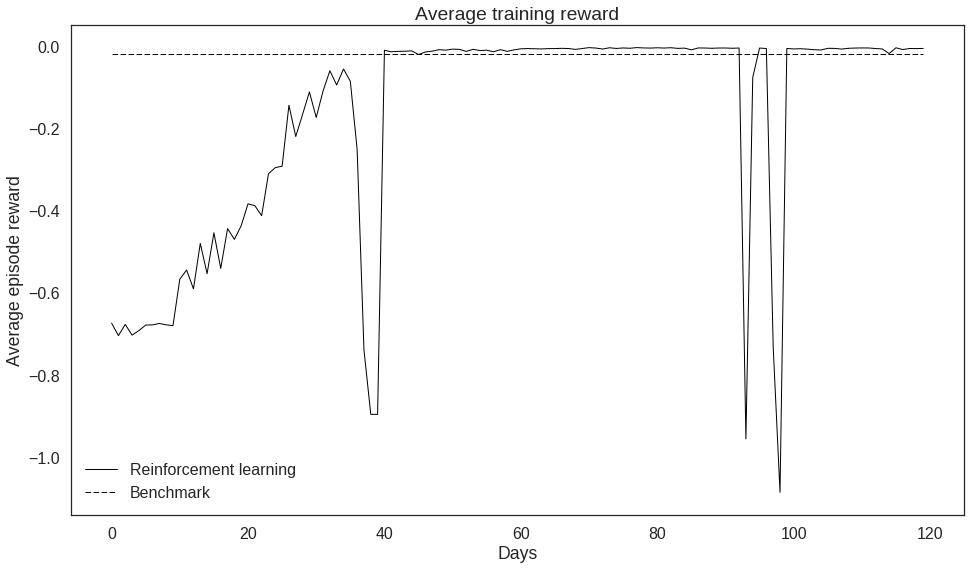

In [24]:

f = plt.figure()
f.set_size_inches(16, 9)
_ = plt.plot(avg_rewards, 'black', label = 'Reinforcement learning')
_ = plt.plot([np.mean(basic_rewards)] * len(avg_rewards),  '--', c = 'black',label = 'Benchmark')
plt.legend()

plt.xlabel('Days')
plt.ylabel('Average episode reward')
plt.title('Average training reward')

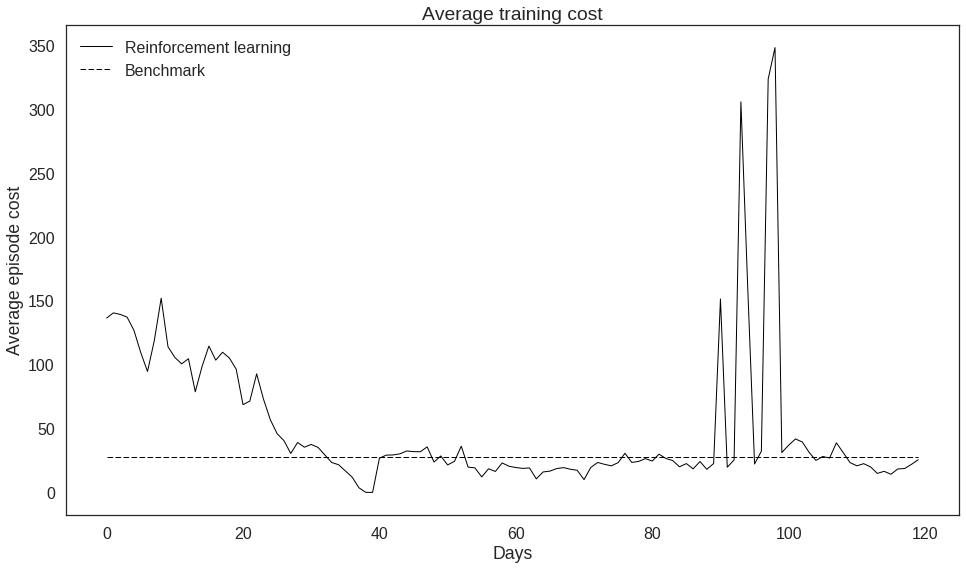

In [25]:
f = plt.figure()
f.set_size_inches(16, 9)
_ = plt.plot(moneys, 'black', label = 'Reinforcement learning')
_ = plt.plot([np.array(basic_monays).mean()] * len(moneys),  '--', c = 'black',label = 'Benchmark')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Average episode cost')
plt.title('Average training cost')

In [26]:
print(np.array(basic_monays).mean(), np.array(basic_monays).std())
print(np.array(rl_monays).mean(), np.array(rl_monays).std())


27.6677036533 7.235064385
23.5674812798 6.19422188744


In [27]:
print(np.array(basic_rewards).mean(), np.array(basic_rewards).std())
print(np.array(rl_rewards).mean(), np.array(rl_rewards).std())

-0.0178458774652 0.00188280494566
-0.0149224428633 0.00163971596039


In [28]:
print(np.array(basic_ons).mean(), np.array(basic_ons).std())
print(np.array(rl_ons).mean(), np.array(rl_ons).std())

0.0823271969434 0.00924205837064
0.072893365752 0.00912818272029


In [29]:
print(np.array(basic_ptimes).mean(), np.array(basic_ptimes).std())
print(np.array(rl_ptimes).mean(), np.array(rl_ptimes).std())

0.116529378792 0.0274848080789
0.112895874464 0.0281807865083


In [30]:
print(np.array(basic_switches).mean(), np.array(basic_switches).std())
print(np.array(rl_switches).mean(), np.array(rl_switches).std())

48.34 5.17149881562
98.2 30.4788451225


## Can we learn a decent policy from a dataset?
this policy should start at benchmark performance

In [61]:
# create a dataset of state-action tuples, coupled with rewards
iters = 100
rewards = []
saved_rewards = []
moneys = []
actions = []
states = []

for i in range(iters):
    env.start_episode(visualise=False)
    play(p, 0, update=False, record_states=True)
    saved_rewards += rewards
    r = sum(rewards)/len(rewards)
    if not i % 10:
        print('Starting iter..', i, r, p.epsilon)
    rewards = []

Starting iter.. 0 -0.00661151087664 -4.768236000010006
Starting iter.. 10 -0.00360556037934 -5.027616000020664
Starting iter.. 20 -0.00728136561149 -5.286996000031323
Starting iter.. 30 -0.00375276894763 -5.546376000041981
Starting iter.. 40 -0.00937510207908 -5.805756000052639
Starting iter.. 50 -0.00562490467509 -6.065136000063298
Starting iter.. 60 -0.00462440097718 -6.324516000073956
Starting iter.. 70 -0.00354384212123 -6.583896000084614
Starting iter.. 80 -0.00498724080703 -6.843276000095273
Starting iter.. 90 -0.00445852832371 -7.102656000105931


In [62]:
saved_states = states.copy()

In [63]:
len(saved_states), len(saved_rewards)

(144000, 144000)

In [64]:
states = np.array(states)
saved_rewards = np.array(saved_rewards)

In [65]:
p.model.n_estimators

15

In [141]:
dataset =  [(r, s) for s, r in zip(states, saved_rewards)]

In [85]:
from random import sample

In [144]:
def get_key(tpl):
    return tpl[0]

In [145]:

dataset_sorted = sorted(dataset, key=get_key)
    

In [256]:
gb = ExtraTreesRegressor(n_estimators=0, max_depth=15, max_leaf_nodes=1000, warm_start=True)



In [257]:
l = len(dataset)
window_start = 0
window_size = int(l/10)
window_end = window_start + window_size
for _ in range(10):
        #sampl = sample(dataset_sorted[int(l/2):], 50000)
    sampl = sample(dataset_sorted[window_start:window_end], 5000)
    gb.n_estimators += 2
    r, s = zip(*sampl)
    gb.fit(s, r)
    window_start = window_end
    window_end = window_start + window_size

In [258]:
p2 = QLearningGBPolicy(alpha=None, gamma=gamma, epsilon=0.0, length = length, max_depth=15, max_leaf_nodes=1000)

In [259]:
p2.model = gb

In [168]:
p2_eval = eval_policy(p2, 50)


KeyboardInterrupt



In [43]:
(p2_moneys,
p2_ons,
p2_ptimes,
p2_rewards,
p2_switches) = (p2_eval['cost'], p2_eval['on_time'], p2_eval['realized'], p2_eval['rewards'], p2_eval['switches'])

In [44]:
np.mean(p2_rewards), np.mean(basic_rewards)

(-0.90797334881717751, -0.017845877465194775)

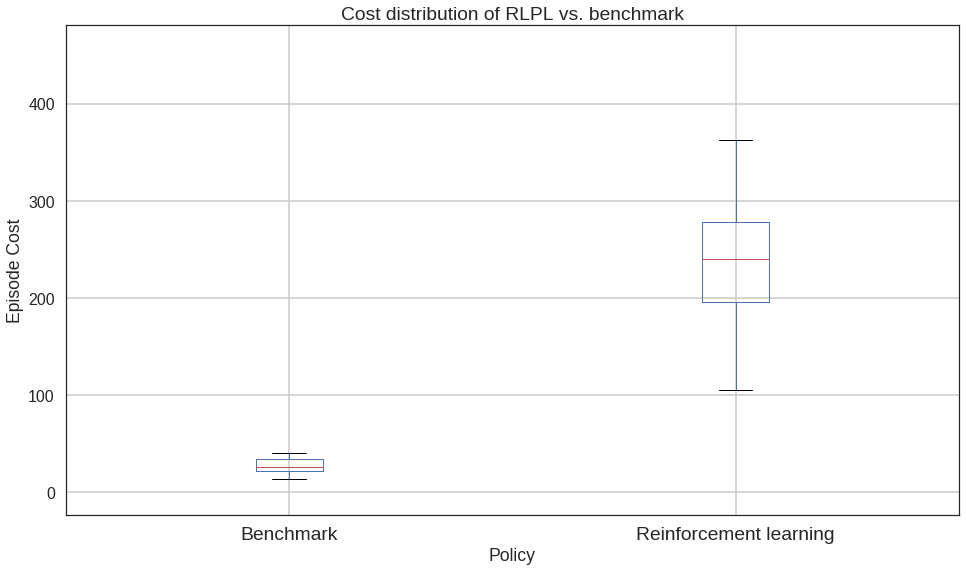

In [69]:
f = plt.figure(facecolor='white')
f.set_size_inches(16, 9)
df = pd.DataFrame()
df['Benchmark'] = basic_monays
df['Reinforcement learning'] = p2_moneys[-50:]
df.boxplot()
plt.xlabel('Policy')
plt.ylabel('Episode Cost')
plt.title('Cost distribution of RLPL vs. benchmark')

VISUALISING
realised_price: 271.1052870433409


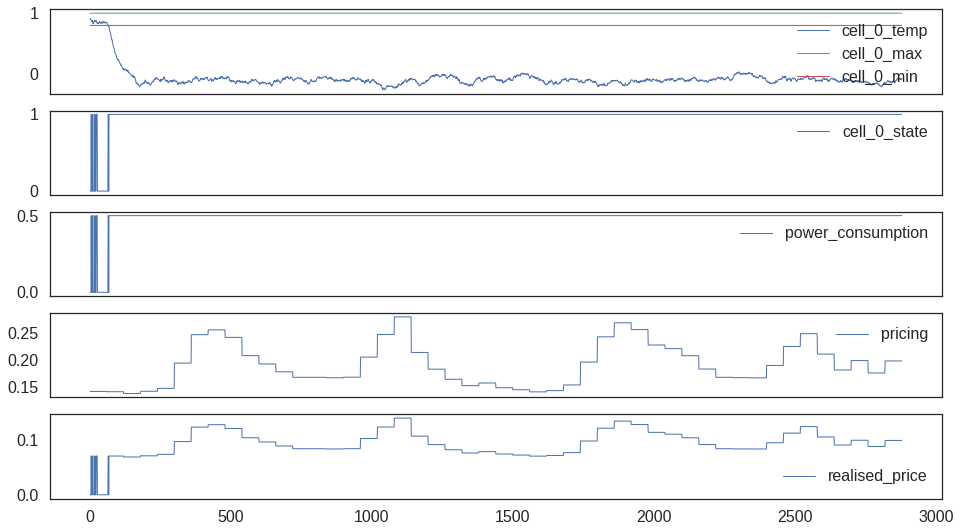

-1.23339068314


In [260]:
rewards = []
env.start_episode(visualise=True)
play(p2, 0, update=False)
#print(price)
print(sum(rewards)/len(rewards))

In [47]:
gb = ExtraTreesRegressor(warm_start=True, n_estimators=15, max_depth=15, max_leaf_nodes=1000)
gb = gb.fit(states, saved_rewards)


In [261]:
p3 = QLearningQeuedRFPolicy(alpha=None, gamma=gamma, epsilon=0.0, length = length, max_depth=15, max_leaf_nodes=1000)
p3.model = gb

In [262]:
p4 = QLearningQeuedRFPolicy(alpha=None, gamma=gamma, epsilon=0.0, length = length, max_depth=15, max_leaf_nodes=1000)
p4.model = gb

In [ ]:
iters = 20
avg_rewards_prelearning = []
moneys_learning = []
for i in range(iters):
    env.start_episode(visualise=False)
    if i > -1:
        play(p4, 0, update = True)
    else:
        play(p3, 0, update = False)
    r = sum(rewards)/len(rewards)
    if not i % 10:
        print('Starting iter..', i, r)
    avg_rewards_prelearning.append(r)
    history = env.episode_history
    history_dataframe =  pd.DataFrame(history).T
    realised_price  = history_dataframe['pricing'] * history_dataframe['power_usage']
    moneys_learning.append(realised_price.sum())
    rewards = []

Starting iter.. 0 -1.24221994334


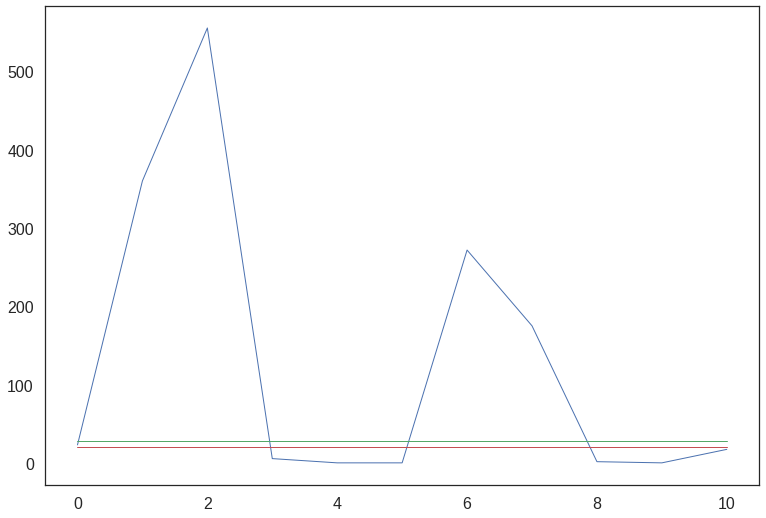

In [242]:
plt.plot(moneys_learning)
plt.plot([np.mean(basic_monays)] * len(moneys_learning))
plt.plot([np.mean(basic_monays) - np.std(basic_monays)] * len(moneys_learning))

In [ ]:
avg_rewards_prelearning_base = avg_rewards_prelearning.copy()

In [ ]:
loc = np.argmin(avg_rewards_prelearning)
avg_rewards_prelearning[loc] = avg_rewards_prelearning[loc + 1]

In [ ]:
f = plt.figure()
f.set_size_inches(16, 9)
plt.plot(avg_rewards_prelearning)
plt.plot(avg_rewards)
plt.plot([np.mean(basic_rewards)] * len(avg_rewards))
plt.plot([np.mean(rl_rewards)] * len(avg_rewards))

In [ ]:
rewards = []
env.start_episode(visualise=True)
play(p4, 0, update=False)
#print(price)
print(sum(rewards)/len(rewards))

In [ ]:
evals_p3 = eval_policy(p3)

In [ ]:
(p3_monays,
p3_ons,
p3_ptimes,
p3_rewards,
p3_switches) = (evals_p3['cost'], evals_p3['on_time'], evals_p3['realized'], evals_p3['rewards'], evals_p3['switches'])

In [ ]:
evals_p4 = eval_policy(p4)

In [ ]:
(p4_monays,
p4_ons,
p4_ptimes,
p4_rewards,
p4_switches) = (evals_p4['cost'], evals_p4['on_time'], evals_p4['realized'], evals_p4['rewards'], evals_p4['switches'])

In [ ]:
np.mean(basic_ons), np.mean(rl_ons), np.mean(p2_ons), np.mean(p4_ons)

In [ ]:
f = plt.figure(facecolor='white')
f.set_size_inches(16, 9)
df = pd.DataFrame()
df['Benchmark'] = basic_monays
df['Prelearnt'] = p2_moneys[-50:]
df['RL (100D)'] = rl_monays[-50:]
df['Prelearnt + RL(40D)'] = p3_monays[-50:]
df['Prelearnt + RL(100D)'] = p4_monays[-50:]
df.boxplot()
plt.xlabel('Policy')
plt.ylabel('Episode Cost')
plt.title('Cost distribution of RLPL vs. benchmark')

In [ ]:
f = plt.figure(facecolor='white')
f.set_size_inches(16, 9)
df = pd.DataFrame()
df['Benchmark'] = basic_ptimes
df['Prelearnt'] = p2_ptimes[-50:]
df['RL (100D)'] = rl_ptimes[-50:]
df['Prelearnt + RL(40D)'] = p3_ptimes[-50:]
df['Prelearnt + RL(100D)'] = p4_ptimes[-50:]
df.boxplot()
plt.xlabel('Policy')
plt.ylabel('Energy Cost')
plt.title('Realized price distributions')